*Created: 08/27/24*

*Most recent update: 09/03/24*

**Authors:** Ismael Mendoza

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['CUDA_VISIBLE_DEVICES']

'1'

In [2]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [3]:
import galsim 
import jax_galsim as xgalsim

2024-09-05 08:32:13.142209: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-09-05 08:32:23.867008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date
import numpy as np

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from tqdm import tqdm

In [6]:
from functools import partial

In [7]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [8]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [9]:
from bpd.chains import inference_loop

In [10]:
jax.devices()

[CudaDevice(id=0)]

In [11]:
GPU = jax.devices('gpu')[0]

In [12]:
jax.config.update("jax_default_device", GPU)

In [13]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

In [14]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # https://gist.github.com/thriveth/8560036

# Drawing methods

In [15]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 4.5
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [16]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

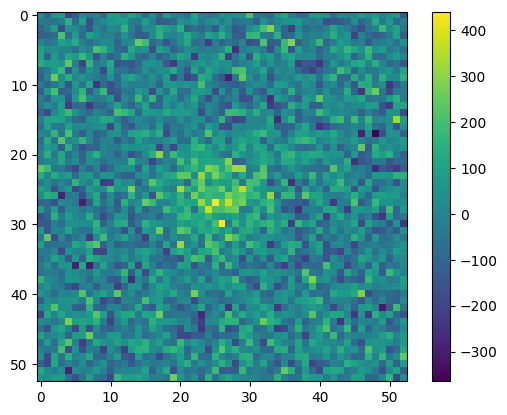

In [17]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [18]:
print(get_snr(im_nn, BACKGROUND))

18.25107


In [19]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)
PIXEL_SCALE_GPU = jax.device_put(PIXEL_SCALE, device=GPU)
TEN_GPU = jnp.array(10., device=GPU)
ONE_GPU = jnp.array(1., device=GPU)
PSF_HLR_GPU = jnp.array(PSF_HLR, device=GPU)
SLEN_GPU = jnp.array(SLEN, device=GPU)

def draw_gal(f, hlr, g1, g2, x, y):
    # x, y arguments in pixels
    gal = xgalsim.Gaussian(flux=TEN_GPU**f, half_light_radius=hlr)
    gal = gal.shift(dx=x*PIXEL_SCALE_GPU, dy=y*PIXEL_SCALE_GPU)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=ONE_GPU, half_light_radius=PSF_HLR_GPU)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN, ## if I change this to SLEN_GPU, get error
                               scale=PIXEL_SCALE_GPU,
                            )
    return image.array

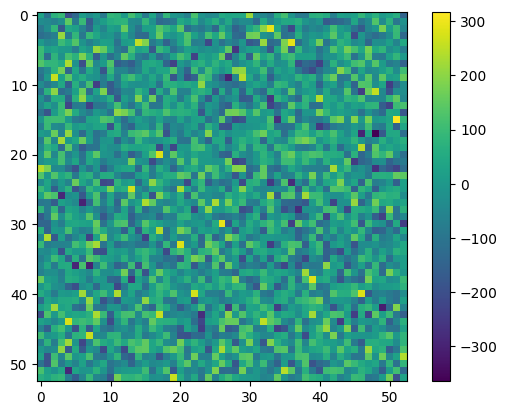

In [20]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

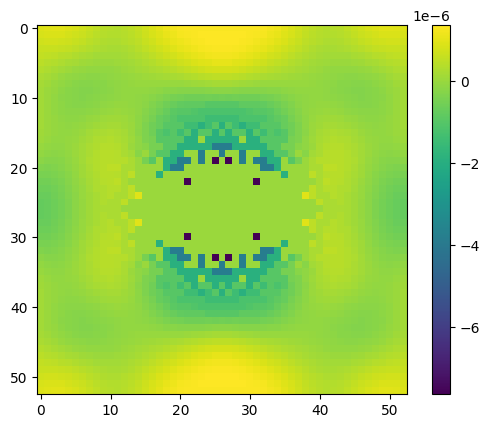

In [21]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [22]:
# timing makes sense
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)

draw_gal_jitted = jax.jit(draw_gal)
draw_gal_jitted(**TRUE_PARAMS_GPU)

%timeit draw_gal_jitted(**TRUE_PARAMS_GPU) # ~ 4x fast
%timeit _draw_gal()

100 μs ± 2.72 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
421 μs ± 7.38 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [23]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (-1., 9.), 'hlr': (0.01, 5.0), 
          'g1': (-0.7, 0.7), 'g2': (-0.7, 0.7), 
          'x': 1,  # sigma (in pixels)
          'y':1 # sigma (in pixels)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [24]:
def prior_sample(rng_key, n:int):
    f = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['f'][0], maxval=BOUNDS_GPU['f'][1])
    hlr = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['hlr'][0], maxval=BOUNDS_GPU['hlr'][1])
    g1 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g1'][0], maxval=BOUNDS_GPU['g1'][1])
    g2 = random.uniform(rng_key, (n,), minval=BOUNDS_GPU['g2'][0], maxval=BOUNDS_GPU['g2'][1])
    x = random.normal(rng_key, (n,)) * BOUNDS_GPU['x'] # mean = 0 , sigma=1
    y = random.normal(rng_key, (n,)) * BOUNDS_GPU['y'] # mean = 0, sigma=1
    
    return {'f': f, 'hlr': hlr, 'g1': g1, 'g2': g2, 'x': x, 'y': y} 

In [25]:
# sample from ball around some dictionary of true params
def sample_ball(rng_key, center_params:dict):
    new = {} 
    keys = random.split(rng_key, len(center_params.keys()))
    rng_key_dict = {p:k for p,k in zip(center_params, keys)}
    for p in center_params:
        centr = center_params[p]
        if p == 'f':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.25, maxval=centr + 0.25)
        elif p == 'hlr':
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.2, maxval=centr + 0.2)
        elif p in {'g1', 'g2'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.025, maxval=centr + 0.025)
        elif p in {'x', 'y'}:
            new[p] = random.uniform(rng_key_dict[p], shape=(), minval=centr - 0.5, maxval=centr + 0.5)
    return new
        


In [26]:
def _logprob_fn(params, data):    
    #prior
    prior = jnp.array(0., device=GPU) 
    for p in ('f', 'hlr', 'g1', 'g2'): # uniform priors
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)
        
    for p in ('x', 'y'): # normal
        sigma = BOUNDS_GPU[p]
        prior += stats.norm.logpdf(params[p], sigma)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)


# Benchmark 2

We want to repeat the above what each chain will have a different random initial position sampled from a ball around the truth.

We target different noise realizations. Each noise realization will have at least 4 chains to be able to estimate R-hat and ESS accurately. 

This time we also vectorize the warmup over each of the chains, i.e. no warmup sharing

**Notes**

- With max_num_doublings = 10 and bad warmup with many chains the computation can take a while...

In [27]:
# what parameter space do we want to explore?
N_WARMUPS = 500 # seems good enough
MAX_DOUBLINGS = 5 # maybe good enough, 10 is a lot and probably need to explore what is good in terms of warmpu first, otherwise one chain can easily get stuck
N_CHAINS = (1, 3, 5, 10, 15, 20, 25) # probably explodes beyond 100

In [28]:
N_SAMPLES = 1000
N_CHAINS_PER_OBJECT = 4

## Run

In [29]:
SEED = 43

In [34]:
results = [] # just for n_chains

In [30]:
# get data
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=25) # maximum number of chains, 25*4, subsample below
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (25, 53, 53)


In [33]:
# base rng key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)}


In [37]:
# we create all the random keys we will need
ball_key, sample_key, warmup_key = random.split(rng_key, 3)

ball_keys = random.split(ball_key, max(N_CHAINS) * N_CHAINS_PER_OBJECT)
warmup_keys = random.split(warmup_key, max(N_CHAINS) * N_CHAINS_PER_OBJECT).reshape(25, 4)
sample_keys = random.split(sample_key, max(N_CHAINS) * N_CHAINS_PER_OBJECT).reshape(25, 4)

warmup_keys.shape



(25, 4)

In [38]:
all_init_positions = jax.vmap(sample_ball, in_axes=(0, None))(ball_keys, TRUE_PARAMS_GPU) # since we run 4 chains per noise realization in this case per object

# reshape appropriately 
all_init_positions = {p:q.reshape(-1, N_CHAINS_PER_OBJECT) for p,q in all_init_positions.items()}
all_init_positions['f'].shape

(25, 4)

In [42]:
# vmap only rng_key
def do_warmup(rng_key, init_position:dict, data):
    
    _logdensity = partial(_logprob_fn, data=data)
    
    warmup = blackjax.window_adaptation(
    blackjax.nuts, _logdensity, progress_bar=False, is_mass_matrix_diagonal=False, 
        max_num_doublings=MAX_DOUBLINGS, 
        initial_step_size=0.1, 
        target_acceptance_rate=0.9 # avoid divergences almost always
    )    
    return warmup.run(rng_key, init_position, N_WARMUPS) # (init_states, tuned_params), adapt_info

    
def do_inference(rng_key, init_state, data, step_size:float, inverse_mass_matrix):
    _logdensity = partial(_logprob_fn, data=data)
    kernel = blackjax.nuts(_logdensity, step_size=step_size, inverse_mass_matrix=inverse_mass_matrix, 
                           max_num_doublings=MAX_DOUBLINGS).step
    return inference_loop(rng_key, init_state, kernel=kernel, n_samples=N_SAMPLES) # state, info
    


In [44]:

# two vmaps, one for data and one for 4 chains per data
_run_warmup = jax.vmap(
                    jax.vmap(
                        jax.jit(
                            partial(
                                do_warmup
                            )
                        ), in_axes=(0, 0, None)
                    ), in_axes=(0, 0, 0)                
)
_run_inference = jax.vmap(
                    jax.vmap(
                        jax.jit(
                            partial(
                                do_inference
                            )
                        ), in_axes=(0, 0, None, 0, 0)
                    ), in_axes=(0, 0, 0, 0, 0)            
)


# here we do the warmup independently for every chain regardless of the fact that we target the same data 
print('n_chains:')
for ii, n_chains in enumerate(N_CHAINS):
    print(n_chains)
    
    d = {} 

    # prepare random keys
    _wkeys = warmup_keys[:n_chains]
    _skeys = sample_keys[:n_chains]

    # prepare initialization 
    _init_positions = {p:q[:n_chains, :] for p,q in all_init_positions.items()}
    _data_gpu1 = data_gpu[:n_chains, :, :]


    if ii==0:
        # compilation times
        t1 = time.time()
        (_init_states, _tuned_params), _ = jax.block_until_ready(_run_warmup(_wkeys, _init_positions, _data_gpu1))            
        t2 = time.time()
        d['warmup_comp_time'] = t2 - t1 

        t1 = time.time()
        _ = jax.block_until_ready(_run_inference(_skeys, _init_states, _data_gpu1, 
                                                            _tuned_params['step_size'], 
                                                            _tuned_params['inverse_mass_matrix']))
        t2 = time.time()
        d['inference_comp_time'] = t2 - t1 

    # run times
    t1 = time.time()
    (init_states, tuned_params), adapt_info = jax.block_until_ready(_run_warmup(_wkeys, _init_positions, _data_gpu1))
    t2 = time.time()
    d['warmup_run_time'] = t2 - t1 

    t1 = time.time()
    states, infos = jax.block_until_ready(_run_inference(_skeys, init_states, _data_gpu1, 
                                                         tuned_params['step_size'], 
                                                         tuned_params['inverse_mass_matrix']
                                                        ))
    t2 = time.time()
    d['inference_run_time'] = t2 - t1 

    # save states and info for future reference
    d['states'] = states
    d['info'] = infos
    d['adapt_info'] = adapt_info
    
    results.append(d)
print('DONE!')

n_chains:
1
3
5
10
15
20
25
DONE!


In [45]:
results[-1]['states'].position['f'].shape

(25, 4, 1000)

In [46]:
results_dict = {n_chains:results[ii] for ii, n_chains in enumerate(N_CHAINS)}

## save run

In [48]:
# jnp.save(f'results_benchmark-v2_3_{SEED}.npy', results_dict)

## Diagnostic plots

In [15]:
seed = 43
d = jnp.load(f'results_benchmark-v2_3_{seed}.npy', allow_pickle=True)[()]

In [16]:
N_CHAINS = np.array(list(d.keys()))
N_CHAINS

array([ 1,  3,  5, 10, 15, 20, 25])

In [52]:
d[25]['states'].position['g1'].shape # check

(25, 4, 1000)

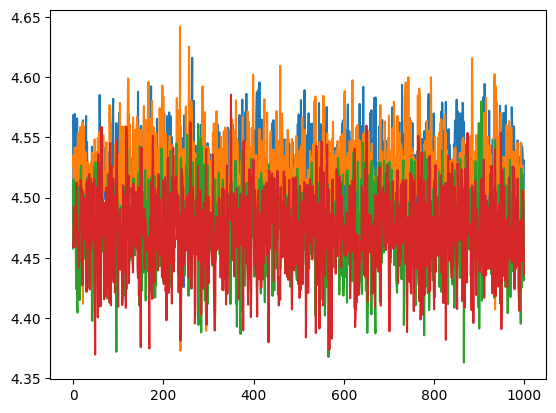

In [54]:
# example chains
plt.plot(d[25]['states'].position['f'][0, 0])
plt.plot(d[25]['states'].position['f'][0, 1])
plt.plot(d[25]['states'].position['f'][1, 0, :])
plt.plot(d[25]['states'].position['f'][1, 1, :])

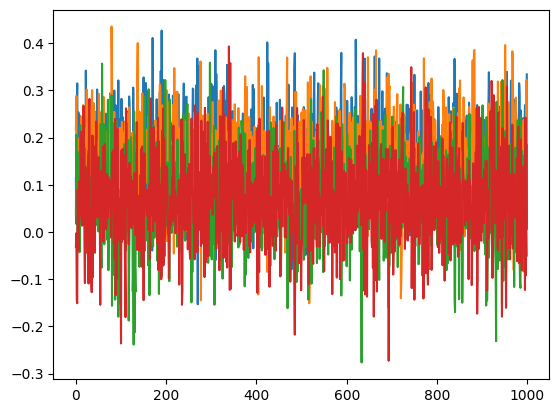

In [55]:
# example chains
plt.plot(d[25]['states'].position['g1'][0, 0])
plt.plot(d[25]['states'].position['g1'][0, 1])
plt.plot(d[25]['states'].position['g1'][1, 0, :])
plt.plot(d[25]['states'].position['g1'][1, 1, :])

In [56]:
d.keys()

dict_keys([1, 3, 5, 10, 15, 20, 25])

In [58]:
_ess

98423.07727188882

In [64]:
_ess/ _tt

799.5504401025775

In [67]:
d[25]['warmup_run_time'] + d[25]['inference_run_time']

123.09802150726318

Text(0.5, 0, 'n_chains')

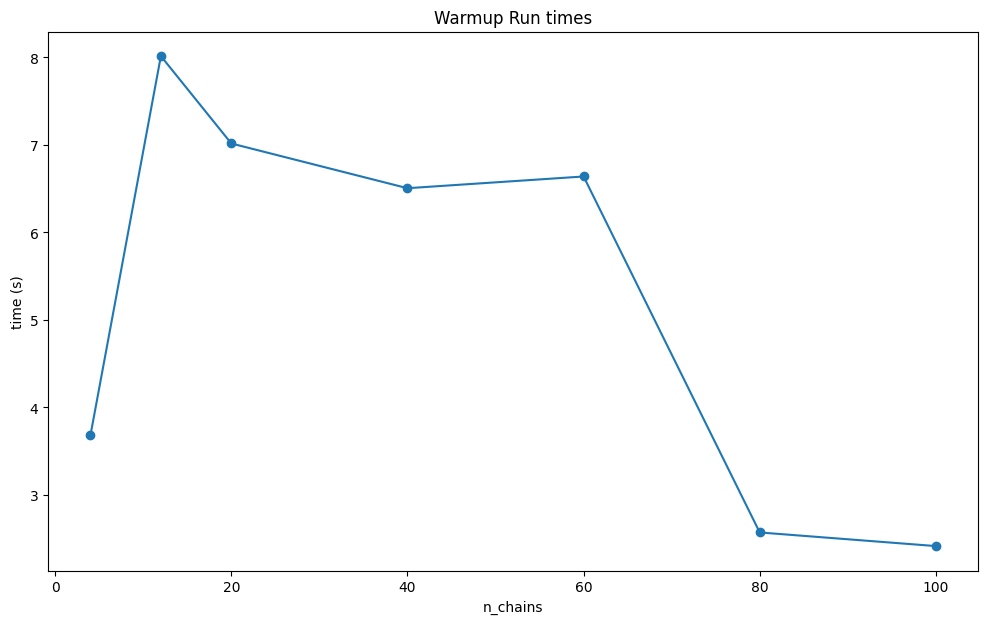

In [22]:

plt.figure(figsize=(12,7))

plt.title("Warmup Run times")

rt = [d[n]['warmup_run_time'] for n in N_CHAINS]

plt.plot(N_CHAINS*4, rt, '-o', color='C0')


plt.ylabel("time (s)")
plt.xlabel("n_chains")


Text(0.5, 0, 'n_chains')

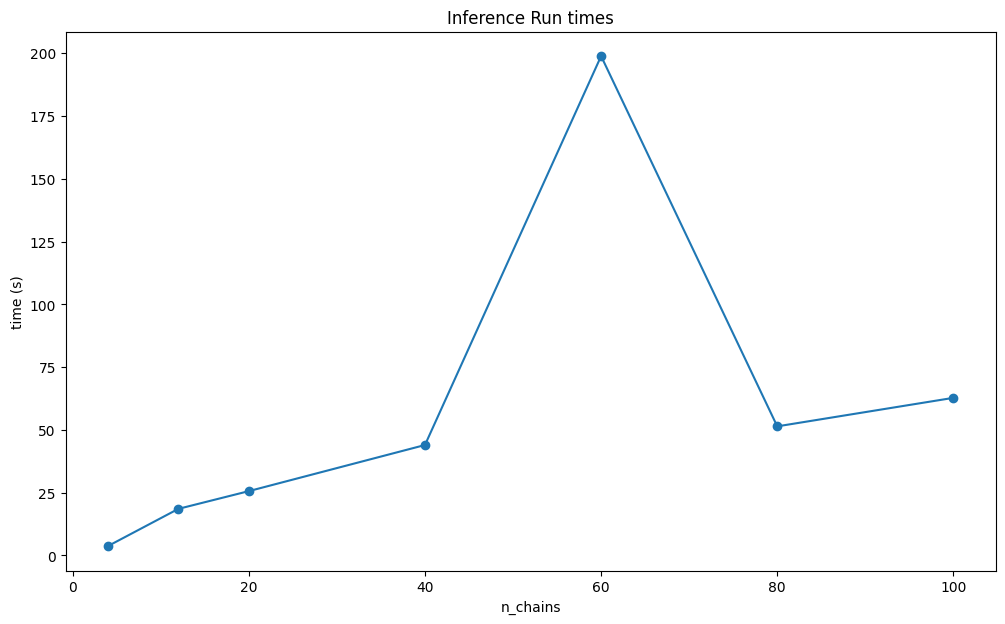

In [19]:

plt.figure(figsize=(12,7))

plt.title("Inference Run times")

rt = [d[n]['inference_run_time'] for n in N_CHAINS]

plt.plot(N_CHAINS*4, rt, '-o', color='C0')


plt.ylabel("time (s)")
plt.xlabel("n_chains")


(0.0, 5.0)

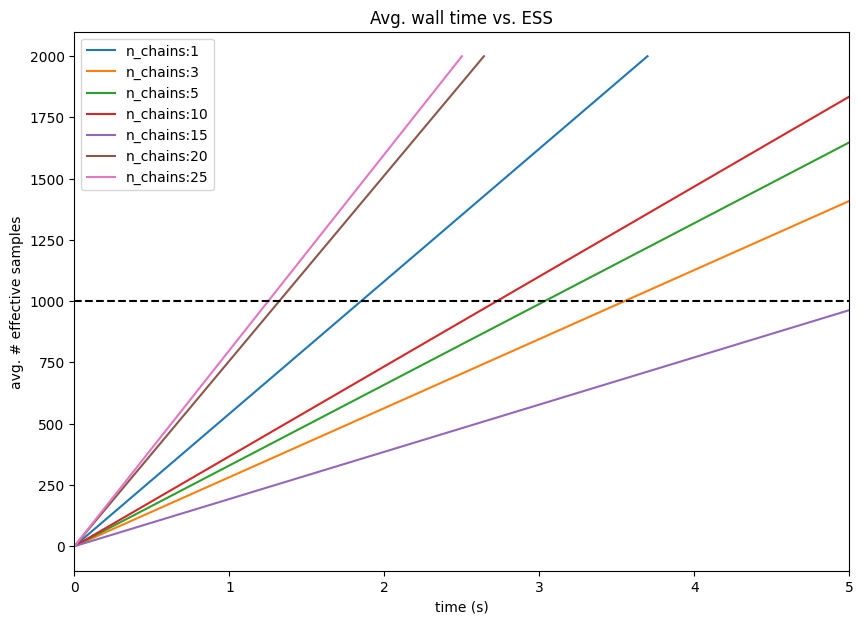

In [66]:
## now for the money plot
# as a function of time how many effective samples can we get? 
plt.figure(figsize=(10,7))
plt.title("Avg. wall time vs. ESS")

avg_time_per_eff_sample = []
for n in N_CHAINS:
    _ess = np.sum([ jnp.clip(effective_sample_size(d[n]['states'].position['g1'][ii], chain_axis=0, sample_axis=1), max=(4*1000)) for ii in range(n)])
    _tt = d[n]['warmup_run_time'] + d[n]['inference_run_time']
    avg_time_per_eff_sample.append( _tt / _ess)
    
avg_time_per_eff_sample = np.array(avg_time_per_eff_sample)
    


for ii, n in enumerate(N_CHAINS):
    mean_t = avg_time_per_eff_sample[ii]
    x = mean_t * np.arange(0, 2000)
    y = np.arange(0, 2000)
    plt.plot(x, y, '-', label=f'n_chains:{n}')

plt.xlabel("time (s)")
plt.ylabel("avg. # effective samples")
plt.legend()
plt.axhline(1000, color='k', linestyle='--')
plt.xlim(0, 5)


Text(0, 0.5, 'ESS / sec ')

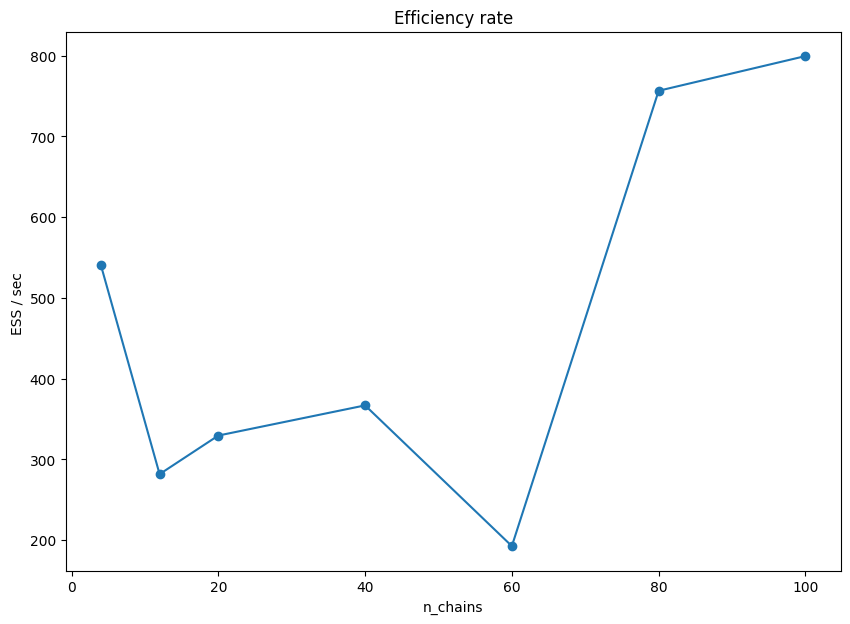

In [21]:
# ess / sec / n_object vs n_object
plt.figure(figsize=(10,7))
plt.title("Efficiency rate")

rates = []
for n in N_CHAINS:
    _ess = np.sum([ jnp.clip(effective_sample_size(d[n]['states'].position['g1'][ii], chain_axis=0, sample_axis=1), max=(4*1000)) for ii in range(n)])
    _tt = d[n]['warmup_run_time'] + d[n]['inference_run_time']
    rates.append( _ess / _tt ) 
    

plt.plot(N_CHAINS*4, rates, '-o') 
plt.xlabel("n_chains")
plt.ylabel("ESS / sec ")


1 4000.0 7.398495197296143
3 12000.0 42.59321403503418
5 20000.0 60.690821170806885
10 40000.0 109.02096652984619
15 57494.89811397928 298.4550025463104
20 77771.69930304367 102.79310202598572
25 98423.07727188882 123.09802150726318


Text(0, 0.5, 'ESS / sec / n_objects')

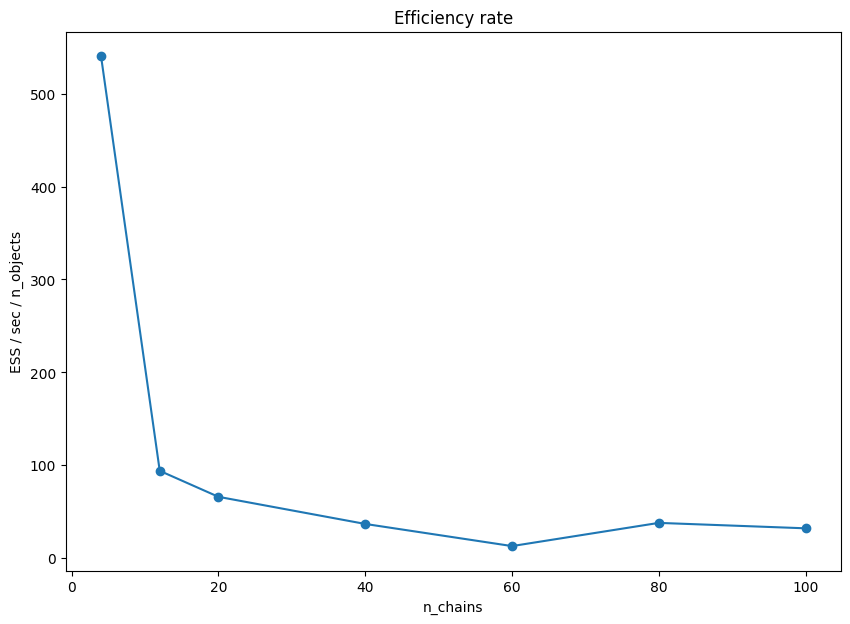

In [93]:
# ess / sec / n_object vs n_object
plt.figure(figsize=(10,7))
plt.title("Efficiency rate")

rates = []
for n in N_CHAINS:
    _ess = np.sum([ jnp.clip(effective_sample_size(d[n]['states'].position['g1'][ii], chain_axis=0, sample_axis=1), max=(4*1000)) for ii in range(n)])
    _tt = d[n]['warmup_run_time'] + d[n]['inference_run_time']
    print(n, _ess, _tt)
    rates.append( _ess / _tt / n) 
    

plt.plot(N_CHAINS*4, rates, '-o') 
plt.xlabel("n_chains")
plt.ylabel("ESS / sec / n_objects")


In [88]:
effective_sample_size(d[5]['states'].position['g1'][2], chain_axis=0, sample_axis=1)

Array(4858.94233495, dtype=float64)

In [89]:

d[5]['states'].position['g1'].shape

(5, 4, 1000)

In [85]:
 jnp.clip(effective_sample_size(d[n]['states'].position['g1'][ii], chain_axis=0, sample_axis=1), max=(4*1000))

Array(4000., dtype=float64)

In [17]:
N_CHAINS

array([ 1,  3,  5, 10, 15, 20, 25])

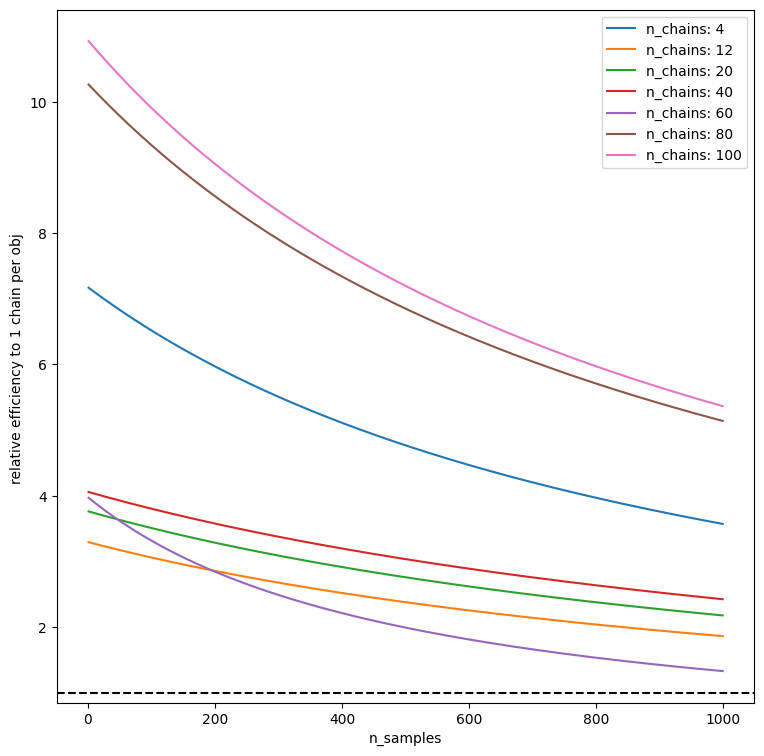

In [20]:
# assuming these results hold for arbitrary number of objects
# let's do just # samples later do effective samples

# we will compute the relative efficiency per objt as a function of samples. 
# i.e. time to get n_samlpes / per_obj w/ N_chains / (time to get n_samples per_obj w/ 1 chain)


# pr obb comparison only valid with > 100 with multilpe number of objects

time1 = 6.6 # time to run 1 chain in sec to get 1000 samples for 1 obj, previos experiment. 

plt.figure(figsize=(9, 9))

n_samples = np.arange(1, 1000)

times = {n:[] for n in N_CHAINS}
for n in N_CHAINS:
    # warmup is fixed regardless of how many samples we want
    # inference is for 1000 samples per obj always so divide by 1000
    t = (d[n]['warmup_run_time'] + (d[n]['inference_run_time'] / 1000 * n_samples) ) /  (n*4)# for simplicity assume each chain targets a different objec, even though each 4 chains share 1 obj
    times[n] = t
    
for n in N_CHAINS:
    plt.plot(n_samples, time1 / times[n], label=f'n_chains: {n*4}')
    
plt.legend()

plt.ylabel("relative efficiency to 1 chain per obj ")
plt.xlabel("n_samples")

plt.axhline(1.0, color='k', linestyle='--')